In [1]:
__author__ = 'Ragadeepika Pucha <rpucha@arizona.edu>, Stephanie Juneau <stephanie.juneau@noirlab.edu>' 
__version__ = '20230612' 
__datasets__ = ['sdss_dr16', 'desi_edr']  
__keywords__ = ['sparcl', 'spectra', 'database'] 

# Comparing SDSS and DESI spectra using SPARCL

*Ragadeepika Pucha (U.Arizona), Stéphanie Juneau (NOIRLab), and the Astro Data Lab Team*

### Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & Setup](#imports)
* [SPARCL](#sparcl)
* [Candidate Selection](#cand_sel)
    * [Data Discovery](#data)
    * [Common Targets between SDSS DR16 and DESI EDR](#common)
    * [Selecting Galaxies with [OII] measurements](#oii_emission)
* [Accessing Spectra](#spectral_access)
    * [Comparison of SDSS DR16 and DESI EDR Spectra](#spec_comparison)
* [Resources, References and Acknowledgements](#resources)

<a class="anchor" id="goals"></a>
# Goals

In this notebook, we use [SPARCL](https://astrosparcl.datalab.noirlab.edu/sparc/) (SPectra Analysis and Retrievable Catalog Lab) to compare SDSS DR16 and DESI EDR spectra. We show how to use the SPARCL data discovery to access available spectra of sources in a specific region of the sky with redshift and spectype constraints. We further compare the spectra from SDSS DR16 and DESI EDR.

# Summary

Spectroscopic study of astronomical objects is crucial for detailed understanding of their physics and evolution. Stellar spectra inform us about the stars' ages, temperatures, and chemical compositions; while galaxy spectra provide us information about the stellar, gas, and dust properties of galaxies, including their kinematics. Spectroscopic surveys therefore enable the detailed statistical analysis of different samples of sources. Two such important spectroscopic surveys are the *Sloan Digital Sky Survey* ([SDSS](https://www.sdss4.org/dr16/)) and the *Dark Energy Spectroscopic Instrument* ([DESI](https://www.desi.lbl.gov/)) survey.

**Sloan Digital Sky Survey (SDSS)**

The SDSS uses the 2.5-m optical telescope at Apache Point Observatory in New Mexico, and has been collecting photometric and spectroscopic data since more than 20 years now. 
The spectroscopic survey for SDSS I/II (2000-2008) was conducted using the "SDSS" spectrograph, that collected spectra from 640 objects at a single time. For SDSS III and later, the existing spectrograph was retired and the 1000-fiber "BOSS" spectrograph was incorporated. Information about the design and performance of these spectrographs is presented in [Smee et al. 2013](https://ui.adsabs.harvard.edu/abs/2013AJ....146...32S/abstract).

**Dark Energy Spectroscopic Instrument (DESI)**

The DESI survey is currently being conducted using the 4-m Mayall Telescope, Kitt Peak Observatory. The 5000-fiber spectrograph has been taking spectra of stars, galaxies, and quasars since 2020. In just over one year, the number of spectra from DESI has surpassed all the existing spectroscopic surveys, including SDSS. The DESI Early Data Release (EDR) is the first public data release that consists of some commissioning data and all of the survey validation data. The overview of the instrument is presented in [Abareshi et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv220510939A/abstract). 

The main comparison between SDSS (BOSS) and DESI spectroscopic surveys are summarized in the table below.

|    Property                        |     SDSS  (BOSS)          | DESI spectrograph          |
|------------------------------------|---------------------------|----------------------------|
|    Fiber diameter                   |          3"  (2")         |          1.5"              |
| Number of spectra at a single time |        640 (1000)         |       5000                 |                       
| Wavelength coverage                | 3800 - 9200 $\mathring A$ |  3600 - 9800 $\mathring A$ |
| Spectral resolution                |  110 - 190 km/s           |   60 - 150 km/s            |
| Targets                            |   r < 17.7 mag            |    r < 24.5 mag            |
| Spatial density                    |    ~ 90 $\rm deg^{-2}$    |     ~ 700 $\rm deg^{-2}$   |

In this notebook, we showcase the data discovery feature of SPARCL and then show how to access SDSS DR16 and DESI EDR spectra using SPARCL. We further compare the spectra of common objects, focusing on the flux and the spectral resolution that is achievable from the two surveys.

<a class="anchor" id="attribution"></a>
# Disclaimer & Attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="imports"></a>
# Imports and Setup

In [2]:
import numpy as np
np.seterr(divide = 'ignore')    ## Ignores division by zero warning

from astropy.table import Table, join, hstack
from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u

import matplotlib.pyplot as plt
%matplotlib inline

# Data Lab
from dl import queryClient as qc

## SPARCL
from sparcl.client import SparclClient

In [3]:
## Making the matplotlib plots look nicer
settings = {
    'font.size':20,
    'axes.linewidth':2.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':2.0,
    'xtick.minor.width':1.5,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':2.0,
    'ytick.minor.width':1.5,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True
}

plt.rcParams.update(**settings)

<a class="anchor" id="sparcl"></a>
# SPARCL

SPARCL (SPectra Analysis and Retrievable Catalog Lab) is a spectral access service of the Community Science and Data Center (CSDC) program of NSF's NOIRLab. It enables fast data discovery and spectral access that matches the user's specifications. It currently hosts all of SDSS DR16 and DESI EDR data. More information about this service is accessible [here](https://sparclclient.readthedocs.io/en/latest/). An introductory notebook on how to use SPARCL is available [here](https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/How_to_use_SPARCL.ipynb).

In [4]:
## Load the SPARCL client for data discovery and spectral access

client = SparclClient()

In [5]:
client

(sparclclient:1.2.0b4.dev2, api:9.0, https://astrosparcl.datalab.noirlab.edu/sparc, verbose=False, connect_timeout=1.1, read_timeout=5400.0)

<a class="anchor" id="cand_sel"></a>
# Candidate Selection

We select sources from both SDSS and DESI that have the following constraints:

    1. 208.4 ≤ R.A. ≤ 210.2
    2. 4.8 ≤ Dec ≤ 6.4
    3. 0.1 ≤ z ≤ 0.15
    4. SPECTYPE = GALAXY
    
The region selected is part of the SDSS Great Wall ([Vogeley et al. 2004](https://ui.adsabs.harvard.edu/abs/2004ogci.conf....5V/abstract), [Einasto et al. 2011](https://ui.adsabs.harvard.edu/abs/2011ApJ...736...51E/abstract)). Both SDSS and DESI have spectra in this region. It is therefore perfect for our comparison. The redshift cut is motivated by the SDSS Great Wall structure and is selected so as to compare the [OII] emission line in this region.

<a class="anchod" id="data"></a>
## Data Discovery

In [6]:
## The outfields that are required as output from SPARCL
out = ['sparcl_id', 'specid', 'ra', 'dec', 'redshift'] 

## Constraints
## SPECTYPE = 'GALAXY'
## 208.4 <= RA <= 210.2
## 4.8 <= DEC <= 6.4
## 0.1 <= Redshift <= 0.15
## SPECPRIMARY = True -- consider only primary spectra
## "datasetgroup" denotes the required survey (SDSS_BOSS for SDSS-DR16 (SDSS+BOSS data), and DESI for DESI EDR data (will be updated with future releases))

sdss_cons = {'spectype':['GALAXY'], 'ra':[208.4, 210.2], 'dec':[4.8, 6.4], 'specprimary': [True], 'datasetgroup': ['SDSS_BOSS'], 'redshift': [0.1, 0.15]}
desi_cons = {'spectype':['GALAXY'], 'ra':[208.4, 210.2], 'dec':[4.8, 6.4], 'specprimary': [True], 'datasetgroup': ['DESI'], 'redshift': [0.1, 0.15]} 

In [7]:
rec_sdss = client.find(outfields=out, constraints=sdss_cons, limit = 5000)
rec_desi = client.find(outfields=out, constraints=desi_cons, limit = 5000)

In [8]:
ra_sdss = np.array([rec['ra'] for rec in rec_sdss.records])
dec_sdss = np.array([rec['dec'] for rec in rec_sdss.records])

ra_desi = np.array([rec['ra'] for rec in rec_desi.records])
dec_desi = np.array([rec['dec'] for rec in rec_desi.records])

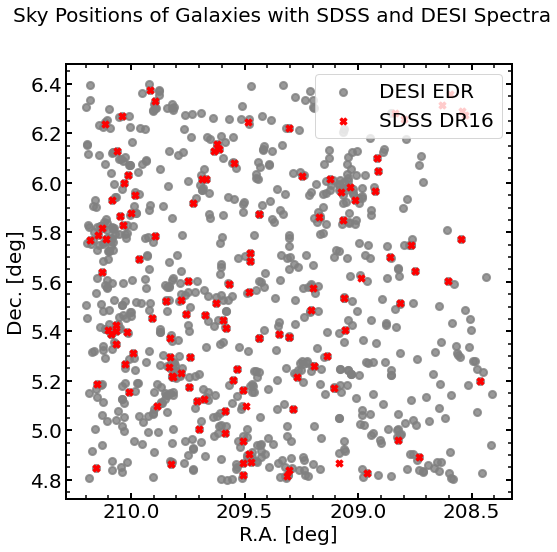

In [9]:
## Overlap of sources

plt.figure(figsize = (8,8))

plt.suptitle('Sky Positions of Galaxies with SDSS and DESI Spectra', fontsize = 20)

plt.scatter(ra_desi, dec_desi, color = 'grey', marker = 'o', s = 50, alpha = 0.8, lw = 2.0, label = 'DESI EDR')
plt.scatter(ra_sdss, dec_sdss, color = 'r', marker = 'X', s = 50, label = 'SDSS DR16')
plt.gca().invert_xaxis()
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec. [deg]')
plt.legend(loc = 'upper right')

From this figure, we clearly see that the DESI target density is much higher than SDSS.

<a class="anchod" id="common"></a>
## Common Targets between SDSS DR16 and DESI EDR

We use the astropy's `search_around_sky` function to find common sources between the two catalogs.

In [10]:
## Find common sources between SDSS and DESI

cat_desi = SkyCoord(ra = ra_desi*u.deg, dec = dec_desi*u.deg)
cat_sdss = SkyCoord(ra = ra_sdss*u.deg, dec = dec_sdss*u.deg)

ii_desi, ii_sdss, _, _ = search_around_sky(cat_desi, cat_sdss, 0.5*u.arcsec)

In [11]:
desi_common = [rec_desi.records[ii] for ii in ii_desi]
sdss_common = [rec_sdss.records[ii] for ii in ii_sdss]

In [12]:
t_desi_common = Table(desi_common)
t_sdss_common = Table(sdss_common)

In [13]:
## Combining the two tables into a single table

t_comb = hstack([t_desi_common, t_sdss_common], table_names=['desi', 'sdss'])

In [14]:
print ('Number of unique SDSS objects: ', len(np.unique(t_comb['specid_sdss'])))
print ('Number of unique DESI objects: ', len(np.unique(t_comb['specid_desi'])))

Number of unique SDSS objects:  109
Number of unique DESI objects:  110


In [15]:
## This suggests that one SDSS object has been selected as two DESI objects.
## We remove that particular object from our selection

sdss_ids_unique, n_counts = np.unique(t_comb['specid_sdss'].data, return_counts = True)
sdss_id_repeated = sdss_ids_unique[n_counts > 1]

## Removing this particular object
t_comb_unique = t_comb[~(t_comb['specid_sdss'].data == sdss_id_repeated)]

In [16]:
z_desi = t_comb_unique['redshift_desi']
z_sdss = t_comb_unique['redshift_sdss']

In [17]:
len(z_desi), len(z_sdss)

(108, 108)

Text(0, 0.5, '$z_{spec}$ (DESI)')

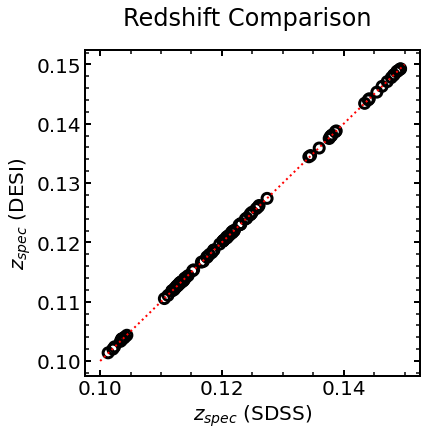

In [18]:
# Comparison of redshifts
plt.figure(figsize = (6,6))
plt.suptitle('Redshift Comparison')

plt.scatter(z_sdss, z_desi, edgecolors = 'k', marker = 'o', s = 100, lw = 3.0, facecolors = 'none')
plt.plot([0.1, 0.15], [0.1,0.15], ls = ':', color = 'r', lw = 2.0)
plt.xlabel('$z_{spec}$ (SDSS)')
plt.ylabel('$z_{spec}$ (DESI)')

We found 108 common sources between SDSS DR16 and DESI EDR with all our imposed constraits. The above figure compares the redshifts of these common sources from the two surveys. 

<a class="anchod" id="oii_emission"></a>
## Selecting Galaxies with [OII] measurements

The [OII] doublet (3726 $\mathring A$ and 3728 $\mathring A$) is typically hard to resolve, but is often used to select high-redshift emission-line galaxies. To compare the SDSS DR16 and DESI EDR spectra, we want to select the galaxy with high [OII] flux. For this purpose, we first select galaxies in the region of interest with non-zero [OII] measurements.  

We access the "emissionlinesport" catalog from the SDSS DR12 database (`sdss_dr12.emissionlinesport`). More information about this catalog can be found from the [Data Lab Table Browser](https://datalab.noirlab.edu/query.php?name=sdss_dr12.emissionlinesport).

In [19]:
## Query to access galaxies with non-zero [OII] measurements
query = """
SELECT specobjid as specid_sdss, 
flux_oii_3726, flux_oii_3726_err,
flux_oii_3728, flux_oii_3728_err
FROM sdss_dr12.emissionlinesport
WHERE (ra >= 208.4) AND (ra <= 210.2) AND (dec >= 4.8) AND (dec <= 6.4) 
AND (flux_oii_3726_err != 0) AND (flux_oii_3728_err != 0)
"""

In [20]:
print (query)


SELECT specobjid as specid_sdss, 
flux_oii_3726, flux_oii_3726_err,
flux_oii_3728, flux_oii_3728_err
FROM sdss_dr12.emissionlinesport
WHERE (ra >= 208.4) AND (ra <= 210.2) AND (dec >= 4.8) AND (dec <= 6.4) 
AND (flux_oii_3726_err != 0) AND (flux_oii_3728_err != 0)



In [21]:
%%time
t_em = qc.query(sql = query, fmt = 'table')

CPU times: user 19.3 ms, sys: 529 µs, total: 19.9 ms
Wall time: 112 ms


In [22]:
## Find sources from the common SDSS and DESI catalog that has [OII] flux
## This part will change with SPARCL as well

t_oii_comb = join(t_comb_unique, t_em, keys = ['specid_sdss'])

In [23]:
len(t_oii_comb)

89

In [24]:
len(np.unique(t_oii_comb['specid_sdss'])), len(np.unique(t_oii_comb['specid_desi']))

(89, 89)

We finally have 89 galaxies with SDSS DR16 and DESI EDR spectra, that have non-zero [OII] flux in SDSS. 

<a class="anchor" id="spectral_access"></a>
# Accessing Spectra

In this section, we show how to access the spectra of all the selected sources from SDSS and DESI using SPARCL.

In [25]:
## Unique identifiers for SDSS and DESI
ids_sdss = [str(idx) for idx in t_oii_comb['sparcl_id_sdss'].data]
ids_desi = [str(idx) for idx in t_oii_comb['sparcl_id_desi'].data]

In [26]:
## Use client.retrive for spectra
## This retrieves all the 89 spectra at once

sel = ['wavelength', 'flux', 'ivar', 'model', 'sparcl_id']

spec_sdss = client.retrieve(uuid_list=ids_sdss, include = sel)
spec_desi = client.retrieve(uuid_list=ids_desi, include = sel)

In [27]:
## Reorder the records to match the original table

res_sdss = spec_sdss.reorder(ids_sdss)
res_desi = spec_desi.reorder(ids_desi)

<a class="anchor" id="spec_comparison"></a>
## Comparison of SDSS DR16 and DESI EDR Spectra

We compare the SDSS and DESI spectra of the source with the maximum [OII] SNR from SDSS. <br/>
The following function is useful to access any spectra, given its SPARCL record and redshift.

In [28]:
def get_restframe_spectra(sparcl_rec, z, rest_frame = True):
    """
    Function to extract the spectra from a given SPARCL record
    
    Parameters
    ----------
    sparcl_rec : dict
        SPARCL record of a given object
        
    z : float
        Redshift of the object
        
    rest_frame : bool
        Whether or not to return the rest-frame spectra.
        Default is True.
        
    Returns 
    -------
    wavelength : array
        Wavelength array of the spectra. 
        Returns the rest-frame values if rest_frame = True
    
    flux : array
        Flux array of the spectra. 
        Returns the rest-frame values if rest_frame = True
        
    ivar : array
        Inverse variance array of the spectra. 
        Returns the rest-frame values if rest_frame = True
    """
    
    wavelength = sparcl_rec.wavelength
    flux = sparcl_rec.flux
    ivar = sparcl_rec.ivar
    
    if (rest_frame == True):
        wavelength = wavelength/(1+z)
        flux = flux*(1+z)
        ivar = ivar/((1+z)**2)
    
    return (wavelength, flux, ivar)

In [29]:
len(t_oii_comb)

89

In [30]:
total_oii_flux = t_oii_comb['flux_oii_3726'].data + t_oii_comb['flux_oii_3728'].data
total_oii_err = np.sqrt((t_oii_comb['flux_oii_3726_err'].data**2)+(t_oii_comb['flux_oii_3728_err'].data**2))
oii_snr = total_oii_flux/total_oii_err

## Select source with the maximum [OII] flux SNR 
ii = np.argmax(oii_snr)

In [31]:
lam_desi, flux_desi, ivar_desi = get_restframe_spectra(res_desi.records[ii], t_oii_comb['redshift_desi'].data[ii], rest_frame = True)
lam_sdss, flux_sdss, ivar_sdss = get_restframe_spectra(res_sdss.records[ii], t_oii_comb['redshift_sdss'].data[ii], rest_frame = True)

In [32]:
err_sdss = np.sqrt(1/ivar_sdss)
err_desi = np.sqrt(1/ivar_desi)

First, we plot the DESI and SDSS spectra of the same galaxy over the entire common spectral range. The DESI spectrum is shown in black, while the SDSS spectrum is in red.

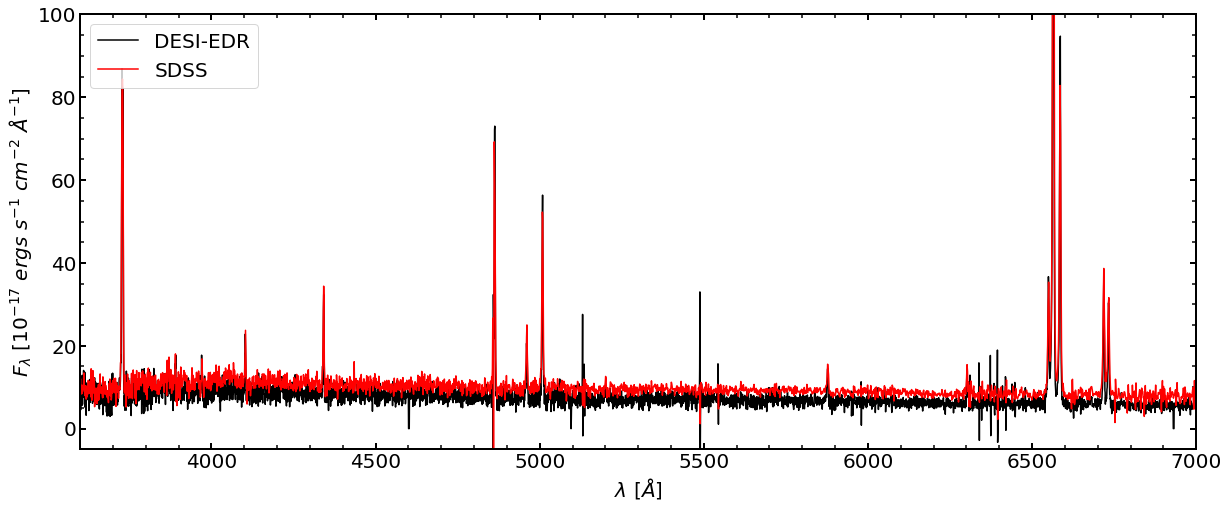

In [33]:
plt.figure(figsize = (20, 8))

plt.plot(lam_desi, flux_desi, color = 'k', label = 'DESI-EDR')
plt.plot(lam_sdss, flux_sdss, color = 'r', label = 'SDSS')
plt.xlim([3600, 7000])
plt.ylim([-5, 100])
plt.xlabel('$\lambda~[\AA]$')
plt.ylabel('$F_{\lambda}~[10^{-17}~ergs~s^{-1}~cm^{-2}~{\AA}^{-1}]$')
plt.legend(loc = 'upper left')

Next, we compare the spectra over a narrow spectra range surrounding the [OII] doublet region. <br/>
The observed spectrum in both the panels is shown in black with the uncertainties as a gray shaded area.

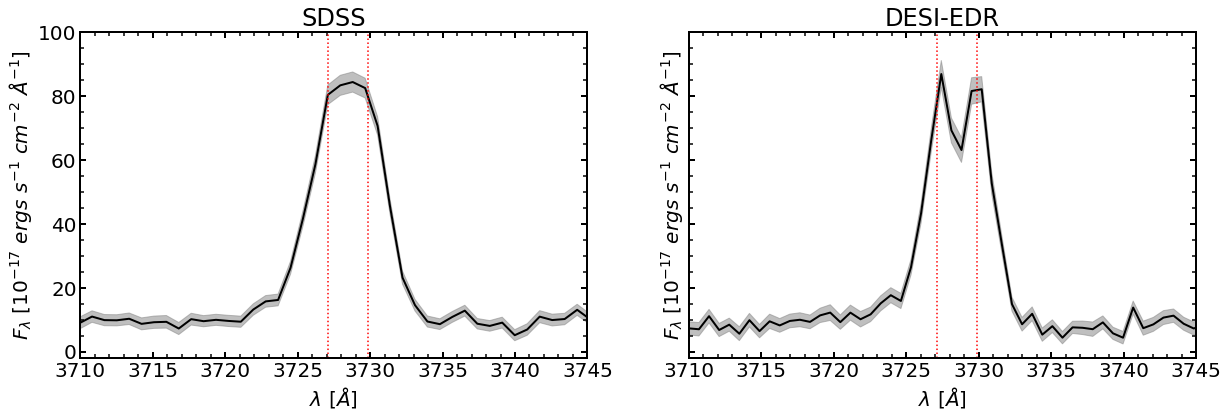

In [34]:
fig, axs = plt.subplots(1,2,figsize = (20,6), sharex = True, sharey = True)

axs[0].plot(lam_sdss, flux_sdss, color = 'k', lw = 2.0)
axs[0].fill_between(lam_sdss, flux_sdss-err_sdss, flux_sdss+err_sdss, color = 'grey', alpha = 0.5)
axs[1].plot(lam_desi, flux_desi, color = 'k', lw = 2.0)
axs[1].fill_between(lam_desi, flux_desi-err_desi, flux_desi+err_desi, color = 'grey', alpha = 0.5)
axs[0].axvline(3727.092, color = 'r', ls = ':')
axs[0].axvline(3729.875, color = 'r', ls = ':')
axs[1].axvline(3727.092, color = 'r', ls = ':')
axs[1].axvline(3729.875, color = 'r', ls = ':')

axs[0].set(xlabel = '$\lambda~[\AA]$', ylabel = '$F_{\lambda}~[10^{-17}~ergs~s^{-1}~cm^{-2}~{\AA}^{-1}]$', title = 'SDSS')
axs[1].set(xlim = [3710,3745], ylim = [-2,100], title = 'DESI-EDR', xlabel = '$\lambda~[\AA]$', ylabel = '$F_{\lambda}~[10^{-17}~ergs~s^{-1}~cm^{-2}~{\AA}^{-1}]$')

plt.show()

From the comparison plots above, we conclude the following:
* The flux from the source measured by SDSS is slightly higher than that measured by DESI. This is more pronounced in the case of the continuum. The observed flux is typically a function of the seeing at the time of spectroscopic observations and the fiber size. This observed difference is therefore partly because of the difference in fiber sizes between the two surveys. The SDSS fiber (3" in diameter) collects more light than the DESI fiber (1.5" in diameter), leading to a higher measured flux.

* The [OII] doublet is clearly resolved in DESI EDR, while it appears as a single emission-line in the case of SDSS. This is expected given that the DESI spectrograph has a higher spectral resolution than the SDSS and BOSS spectrographs, helping us resolve more spectral information. 

* Specifically, the ratio of the two components of [OII] doublet is an important tracer for measuring electron density in HII-regions. Using DESI, we can therefore study such important properties for a large number of galaxies.

* From the error bars on both the spectra, we see that they have similar signal-to-noise ratios. In fact, the exposure time for DESI is planned in such a way that the spectra will have same S/N ratio as SDSS for similar magnitude objects. However, it takes less time for DESI to reach such a S/N compared to SDSS.

* Another important point regarding DESI is that it pushes the target selection to much fainter objects than SDSS. 

#### <a class="anchor" id="resources"></a>
# Resources
* SDSS Website: https://www.sdss4.org/dr16/
* DESI Website: https://www.desi.lbl.gov/
* SPARCL Links: https://sparclclient.readthedocs.io/en/latest/, https://astrosparcl.datalab.noirlab.edu/sparc/
* Schema details about the emissionlinesport catalog: https://datalab.noirlab.edu/query.php?name=sdss_dr12.emissionlinesport
* Introduction to SPARCL notebook: https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/How_to_use_SPARCL.ipynb

# References
* [Abareshi et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv220510939A/abstract)
* [Einasto et al. 2011](https://ui.adsabs.harvard.edu/abs/2011ApJ...736...51E/abstract)
* [Smee et al. 2013](https://ui.adsabs.harvard.edu/abs/2013AJ....146...32S/abstract)
* [Vogeley et al. 2004](https://ui.adsabs.harvard.edu/abs/2004ogci.conf....5V/abstract)

# Acknowledgments

* DESI Data License and Acknowledgements: https://data.desi.lbl.gov/doc/acknowledgments/
* SDSS Data License and Acknowledgements: https://www.sdss4.org/collaboration/#sdss4acknowledgement
* Astro Data Lab Acknowledgments: https://datalab.noirlab.edu/acknowledgements.php
* SPARCL Acknowledgments: https://astrosparcl.datalab.noirlab.edu/sparc/acknowledgments

---